# Data Cleaning

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

DATA_FOLDER_PATH = "datathon-data"
EMISSION_DATA_FILE = "Energy Data - Emissions.csv"
CONSUMPTION_DATA_FILE = "Energy Data - Consumption.csv"
PRODUCTION_DATA_FILE = "Energy Data - Production.csv"

# stocks and commodities data
STOCK_DATA_FILE = "Energy Data - Stocks.csv"
COMMODITY_DATA_FILE = "all_commodities.csv"

def load_data(file_path):
    return pd.read_csv(file_path)

In [15]:
# df_emission = load_data(EMISSION_DATA_FILE)
df_consumption = load_data('/Users/shrek/Downloads/Datathon Data/Energy Data - Consumption.csv')
df_production = load_data('/Users/shrek/Downloads/Datathon Data/Energy Data - Production.csv')
# df_stock = load_data(STOCK_DATA_FILE)
df_commodity = load_data('/Users/shrek/Downloads/Datathon Data/all_commodities.csv')

## Oil Consumption Data

Some info about the columns
- **Description**: seems to be a concatenation of the following the other columns, so I'll drop it here.  
- **Column_Order**: is the order of the column in the original dataset, so I'll drop it here.  
- **Unit**: values are not unique here ('Thousand Barrels per Day', 'Trillion Btu', 'Billion Cubic Feet', 'Thousand Short Tons')
- **Energy Type**: Energy being reported on
- **Energy Category**: Category of energy being reported on(e.g. Propane and Propylene are Hydrocarbon Gas Liquids (HCL) vs. Coal which is just coal)
- **Energy Class**: Parent-level category of energy being reported on (e.g. Coal vs. Natural Gas)
- **Sector**: Sector being reported on (if applicable)

NA values:
**Sector** is the only column with NA values in the oil consumption data. Let's leave it as is for now. 

In [17]:
df_consumption.drop(columns=["Description", "Column_Order"], inplace=True)

In [18]:
# Let's see unique values for each column
print("Energy Type:", df_consumption["Energy Type"].unique())
print("-"*50)
print("Energy Class:", df_consumption["Energy Class"].unique())
print("-"*50)
print("Energy Category:", df_consumption["Energy Category"].unique())
print("-"*50)
print("Sector:", df_consumption["Sector"].unique())

Energy Type: ['Distillate Fuel Oil' 'Propane' 'Kerosene' 'Total' 'Motor Gasoline'
 'Petroleum Coke' 'Residual Fuel Oil' 'Asphalt and Road Oil' 'Propylene'
 'Propane/Propylene' 'Lubricants' 'Other Petroleum Products'
 'Aviation Gasoline' 'Jet Fuel' 'Other Products' 'Geothermal Energy'
 'Solar Energy' 'Wood Energy' 'Total Renewable Energy'
 'Hydroelectric Power' 'Wind Energy' 'Waste Energy'
 'Fuel Ethanol, Excluding Denaturant' 'Biomass Losses and Co-products'
 'Biofuels' 'Renewable Energy' 'Natural Gas' 'Natural Gas - CHP'
 'Natural Gas - Non-CHP' 'Natural Gas - Pipelines and Distro'
 'Natural Gas - Vehicle Fuel' 'Coal' 'Coal - CHP' 'Coal - Non-CHP'
 'Coal - Other - Total']
--------------------------------------------------
Energy Class: ['Petroleum' 'Renewable' 'Natural Gas' 'Coal']
--------------------------------------------------
Energy Category: ['Distillate Fuel Oil' 'HGL' 'Kerosene' 'Total' 'Motor Gasoline'
 'Petroleum Coke' 'Residual Fuel Oil' 'Asphalt and Road Oil' 'Lubricants'

In [19]:
# Unit: Thousand Barrels per Day
# We extract only the data for Petroleum and Total consumption
df_consumption = df_consumption[(df_consumption['Energy Class'] == 'Petroleum') & (df_consumption['Energy Type'] == 'Total')].drop(columns=["Energy Class", "Energy Type", "Energy Category", "Unit", "EIA_ID"])
df_consumption

,YYYYMM,Date,Value,Sector
1833,197301,1/1/1973,2686.283,Residential
1834,197302,2/1/1973,2562.351,Residential
1835,197303,3/1/1973,1746.055,Residential
1836,197304,4/1/1973,1321.203,Residential
1837,197305,5/1/1973,1026.764,Residential
...,...,...,...,...
22602,202307,7/1/2023,90.352,Electric Power
22603,202308,8/1/2023,92.828,Electric Power
22604,202309,9/1/2023,90.611,Electric Power
22605,202310,10/1/2023,70.422,Electric Power


In [20]:
# we cast Value to float, and Date to datetime
df_consumption['Value'] = df_consumption['Value'].astype(float)
df_consumption['Date'] = pd.to_datetime(df_consumption['Date'])


# We aggregate the data across different sectors
df_consumption = df_consumption.groupby("Date").agg({"Value": "sum"}).reset_index()
df_consumption

,Date,Value
0,1973-01-01,19742.551
1,1973-02-01,20010.586
2,1973-03-01,17966.304
3,1973-04-01,16664.773
4,1973-05-01,17489.655
...,...,...
606,2023-07-01,23296.776
607,2023-08-01,23843.214
608,2023-09-01,23011.206
609,2023-10-01,23839.498


In [21]:
# we generate YYYYMM to join with the commodity data later, date is in the format MM/DD/YYYY
df_consumption['YYYYMM'] = df_consumption['Date'].dt.strftime('%Y%m')
# we sort the data by date
df_consumption.sort_values("Date", inplace=True)

In [22]:
df_consumption["Consumption (Thousand Barrels per Day)"] = df_consumption["Value"]
df_consumption.drop(columns=["Date", "Value"], inplace=True)
# re-arrange the order of columns
df_consumption = df_consumption[["YYYYMM", "Consumption (Thousand Barrels per Day)"]]
df_consumption

,YYYYMM,Consumption (Thousand Barrels per Day)
0,197301,19742.551
1,197302,20010.586
2,197303,17966.304
3,197304,16664.773
4,197305,17489.655
...,...,...
606,202307,23296.776
607,202308,23843.214
608,202309,23011.206
609,202310,23839.498


<Axes: title={'center': 'Total Petroleum Consumption in the US'}, xlabel='YYYYMM', ylabel='Thousand Barrels per Day'>

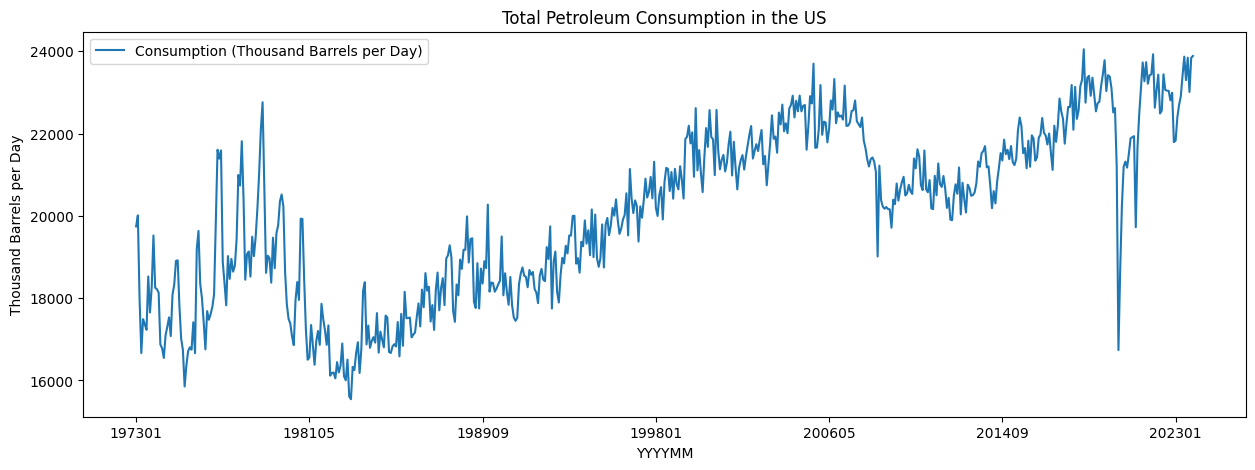

In [23]:
df_consumption.plot(x="YYYYMM", y="Consumption (Thousand Barrels per Day)", figsize=(15, 5), title="Total Petroleum Consumption in the US", ylabel="Thousand Barrels per Day", xlabel="YYYYMM")

## Oil Production Data

Some info about the columns
- **Description**: Description of petroleum import or export and its origin 
- **Column_Order**: is the order of the column in the original dataset, so I'll drop it here.  
- **Unit**: there are two values here ('Trillion Btu', 'Quadrillion Btu')

NA values:
No NA values in the oil production data.

In [24]:
# crude oil unit is in Quadrillion Btu
df_crude_oil_production = df_production[df_production["Description"] == "Crude Oil Production"]
df_crude_oil_production.drop(columns=["Column_Order", "EIA_ID", "Unit", "Date", "Description"], inplace=True)
df_crude_oil_production['Crude Oil Production (Quadrillion Btu)'] = df_crude_oil_production['Value']
df_crude_oil_production.drop(columns=["Value"], inplace=True)
df_crude_oil_production.reset_index(drop=True, inplace=True)
df_crude_oil_production['YYYYMM'] = df_crude_oil_production['YYYYMM'].astype(str)
df_crude_oil_production['Crude Oil Production (Quadrillion Btu)'] = df_crude_oil_production['Crude Oil Production (Quadrillion Btu)'].astype(float)
df_crude_oil_production

/var/folders/k_/dpcvwbqn02gc5_n73bcpnrqh0000gn/T/ipykernel_64420/3597215947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crude_oil_production.drop(columns=["Column_Order", "EIA_ID", "Unit", "Date", "Description"], inplace=True)
/var/folders/k_/dpcvwbqn02gc5_n73bcpnrqh0000gn/T/ipykernel_64420/3597215947.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crude_oil_production['Crude Oil Production (Quadrillion Btu)'] = df_crude_oil_production['Value']
/var/folders/k_/dpcvwbqn02gc5_n73bcpnrqh0000gn/T/ipykernel_64420/3597215947.py:5: SettingWithCopyWarni

,YYYYMM,Crude Oil Production (Quadrillion Btu)
0,197301,1.649833
1,197302,1.525783
2,197303,1.667094
3,197304,1.616791
4,197305,1.665377
...,...,...
606,202307,2.277509
607,202308,2.297896
608,202309,2.258803
609,202310,2.330122


<Axes: title={'center': 'Crude Oil Production in the US'}, xlabel='YYYYMM', ylabel='Quadrillion Btu'>

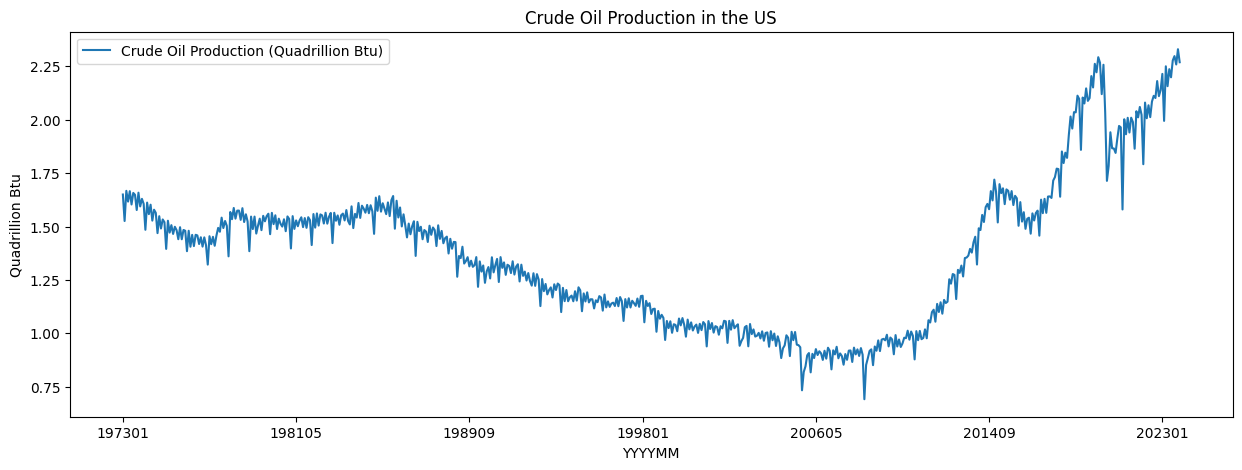

In [25]:
df_crude_oil_production.plot(x="YYYYMM", y="Crude Oil Production (Quadrillion Btu)", figsize=(15, 5), title="Crude Oil Production in the US", ylabel="Quadrillion Btu", xlabel="YYYYMM")

# Currency Data

In [26]:
df_ruble = pd.read_csv("ruble.tsv", delimiter=" ")

In [27]:
# Date: 05-May-2003
df_ruble['Date'] = pd.to_datetime(df_ruble['Date'], format="%d-%b-%Y")
df_ruble_all_time = df_ruble.copy()
df_ruble['YYYYMM'] = df_ruble['Date'].dt.strftime('%Y%m')

# we aggregate the data by month
df_ruble = df_ruble.groupby("YYYYMM").agg({"sdr_ruble_rate": "mean"}).reset_index()
df_ruble

,YYYYMM,sdr_ruble_rate
0,200305,0.022947
1,200306,0.023207
2,200307,0.023564
3,200308,0.023789
4,200309,0.023407
...,...,...
243,202308,0.007860
244,202309,0.007846
245,202310,0.007893
246,202311,0.008352


## Oil Commodity Data

In [28]:
print("Commodity types: ", df_commodity['Commodity_Simple'].unique())

Commodity types:  ['NATURAL_GAS' 'WTI' 'BRENT']


In [29]:
# We'll use Brent Crude Oil prices for now
df_brent = df_commodity[df_commodity['Commodity_Simple'] == 'BRENT']

# we reverse the data to have the oldest data first
df_brent_all_time = df_brent.iloc[::-1].reset_index(drop=True)

# we drop all na values
df_brent = df_brent_all_time.dropna()

# we cast the date to datetime
df_brent['YYYYMM'] = df_brent['Date_Time'].apply(lambda x: (str(x)[:4] + str(x)[5:7]))

# we aggregate the data by month
df_brent = df_brent.groupby("YYYYMM").agg({"Value": "mean"}).reset_index()

# Unit is Dollars per Barrel
df_brent['Brent_Price'] = df_brent['Value']

# we drop the original Value column
df_brent.drop(columns=["Value"], inplace=True)
df_brent

/var/folders/k_/dpcvwbqn02gc5_n73bcpnrqh0000gn/T/ipykernel_64420/2656448959.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brent['YYYYMM'] = df_brent['Date_Time'].apply(lambda x: (str(x)[:4] + str(x)[5:7]))


,YYYYMM,Brent_Price
0,198705,18.580000
1,198706,18.860476
2,198707,19.856522
3,198708,18.979524
4,198709,18.313182
...,...,...
436,202309,93.722381
437,202310,90.595909
438,202311,82.940000
439,202312,77.631053


<Axes: title={'center': 'Brent Crude Oil Prices'}, xlabel='YYYYMM', ylabel='Dollars per Barrel'>

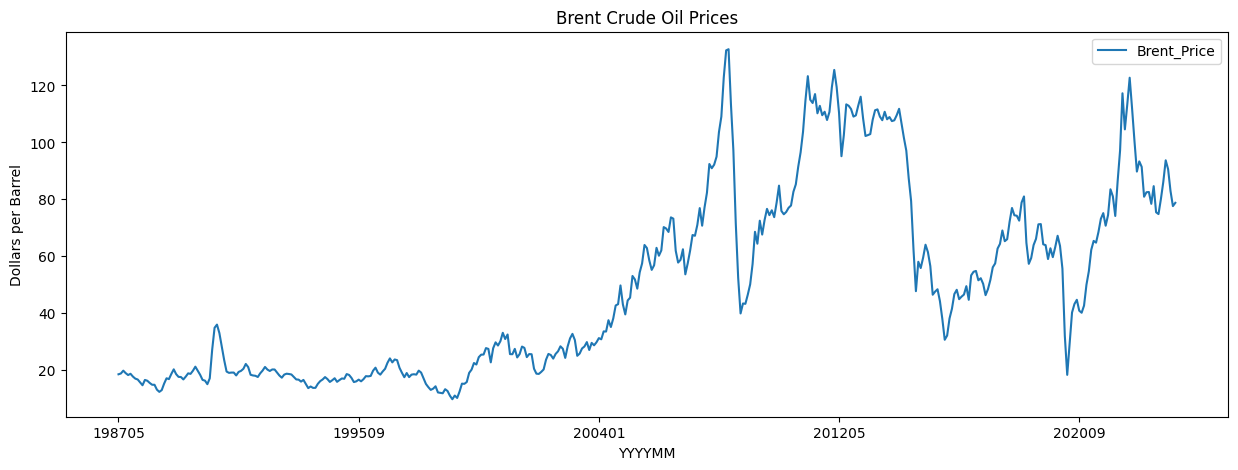

In [30]:
df_brent.plot(x="YYYYMM", y="Brent_Price", figsize=(15, 5), title="Brent Crude Oil Prices", ylabel="Dollars per Barrel", xlabel="YYYYMM")

In [31]:
# we join the consumption data with the brent data
df_consumption_brent = pd.merge(df_consumption, df_brent, on="YYYYMM")

# we join the resulting data with the crude oil production data
df_consumption_brent_production = pd.merge(df_consumption_brent, df_crude_oil_production, on="YYYYMM")

# we join the resulting data with the ruble data
df_consumption_brent_production_ruble = pd.merge(df_consumption_brent_production, df_ruble, on="YYYYMM")

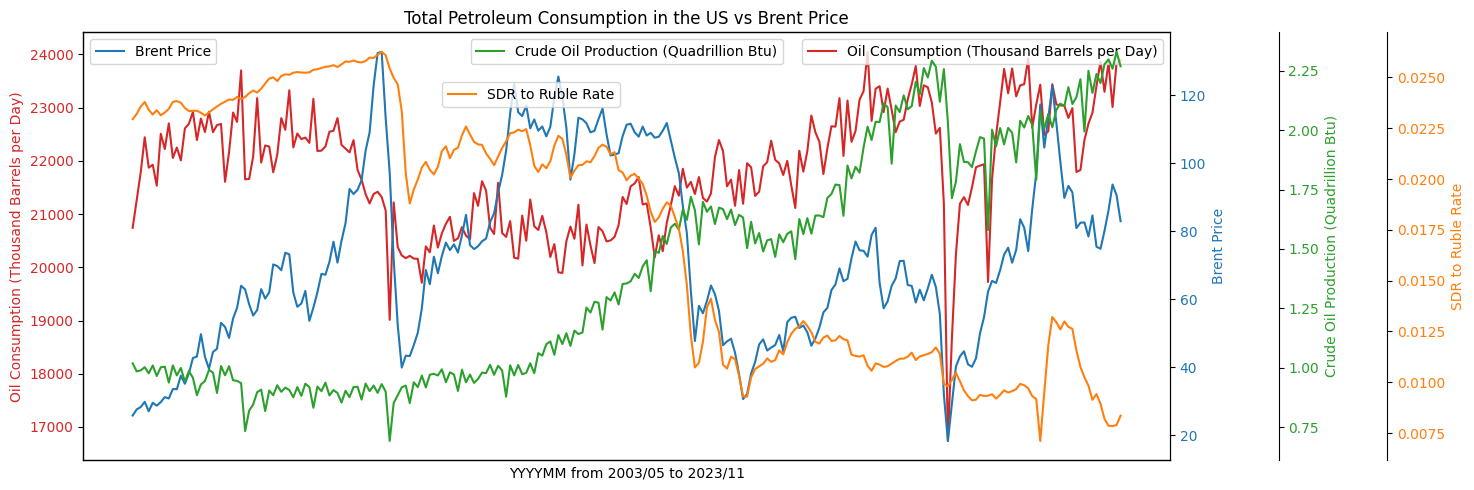

In [32]:
# we plot the data
fig, ax1 = plt.subplots(figsize=(15, 5))

color = 'tab:red'
ax1.set_xlabel('YYYYMM from 2003/05 to 2023/11')
ax1.set_ylabel('Oil Consumption (Thousand Barrels per Day)', color=color)
ax1.plot(df_consumption_brent_production_ruble['YYYYMM'], df_consumption_brent_production_ruble['Consumption (Thousand Barrels per Day)'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(["Oil Consumption (Thousand Barrels per Day)"], loc="upper right")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Brent Price', color='tab:blue')  # we already handled the x-label with ax1
ax2.plot(df_consumption_brent_production_ruble['YYYYMM'], df_consumption_brent_production_ruble['Brent_Price'], color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(["Brent Price"], loc="upper left")

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax3.spines["right"].set_position(("axes", 1.1))
ax3.set_ylabel('Crude Oil Production (Quadrillion Btu)', color='tab:green')  # we already handled the x-label with ax1
ax3.plot(df_consumption_brent_production_ruble['YYYYMM'], df_consumption_brent_production_ruble['Crude Oil Production (Quadrillion Btu)'], color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')
ax3.legend(["Crude Oil Production (Quadrillion Btu)"], loc="upper center")

ax4 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax4.spines["right"].set_position(("axes", 1.2))
ax4.set_ylabel('SDR to Ruble Rate', color='tab:orange')  # we already handled the x-label with ax1
ax4.plot(df_consumption_brent_production_ruble['YYYYMM'], df_consumption_brent_production_ruble['sdr_ruble_rate'], color='tab:orange')
ax4.tick_params(axis='y', labelcolor='tab:orange')
ax4.legend(["SDR to Ruble Rate"], bbox_to_anchor=(0.5, 0.9)) 

ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
fig.autofmt_xdate()# we set the title
plt.title("Total Petroleum Consumption in the US vs Brent Price")

fig.tight_layout()

# Analysis

### Correlation between oil production, consumption and commodity data

In [33]:
df_consumption_brent_production_ruble

,YYYYMM,Consumption (Thousand Barrels per Day),Brent_Price,Crude Oil Production (Quadrillion Btu),sdr_ruble_rate
0,200305,20741.957,25.857727,1.018293,0.022947
1,200306,21259.890,27.652857,0.984680,0.023207
2,200307,21782.098,28.348696,0.988620,0.023564
3,200308,22442.445,29.888095,1.002164,0.023789
4,200309,21871.896,27.112273,0.975968,0.023407
...,...,...,...,...,...
242,202307,23296.776,80.108095,2.277509,0.008193
243,202308,23843.214,86.147727,2.297896,0.007860
244,202309,23011.206,93.722381,2.258803,0.007846
245,202310,23839.498,90.595909,2.330122,0.007893


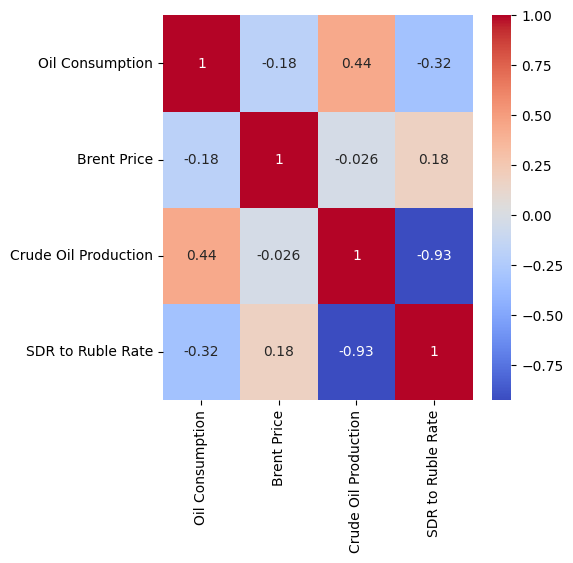

In [34]:
# we beatify the column names
df_consumption_brent_production_ruble[['Oil Consumption', 'Brent Price', 'Crude Oil Production', 'SDR to Ruble Rate']] = df_consumption_brent_production_ruble[['Consumption (Thousand Barrels per Day)', 'Brent_Price', 'Crude Oil Production (Quadrillion Btu)', 'sdr_ruble_rate']]
df_corr_input = df_consumption_brent_production_ruble.drop(columns=["Consumption (Thousand Barrels per Day)", "Brent_Price", "Crude Oil Production (Quadrillion Btu)", "sdr_ruble_rate"])

# let's analyze the correlation between the variables and generate a heatmap
df_corr_input = df_corr_input.drop(columns=["YYYYMM"])
df_corr_input.corr()

import seaborn as sns
# generate a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(df_corr_input.corr(), annot=True, cmap="coolwarm");

### Granger Causality between oil production, consumption and commodity data

In [35]:
maxlag = 12
test   = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    from statsmodels.tsa.stattools import grangercausalitytests
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [36]:
granger_mat = grangers_causation_matrix(df_corr_input, variables = df_corr_input.columns);

# case all values to float
granger_mat = granger_mat.astype(float)

# we use a significance level of 0.05
# granger_mat = granger_mat[granger_mat < 0.05]
# granger_mat = granger_mat.where(granger_mat < 0.05)
granger_mat

,Oil Consumption_x,Brent Price_x,Crude Oil Production_x,SDR to Ruble Rate_x
Oil Consumption_y,1.0000,0.0204,0.0000,0.0079
Brent Price_y,0.4686,1.0000,0.2365,0.0020
Crude Oil Production_y,0.0000,0.0019,1.0000,0.0014
SDR to Ruble Rate_y,0.2588,0.0000,0.0021,1.0000


### Analysis using daily data

In [37]:
# we use ffill to fill the missing values with the previous value
df_brent_all_time.ffill(inplace=True)
df_brent_all_time

,Date_Time,Value,Commodity,Commodity_Simple,Unit
0,1987-05-20,18.63,Brent Crude Oil,BRENT,Dollars per Barrel
1,1987-05-21,18.45,Brent Crude Oil,BRENT,Dollars per Barrel
2,1987-05-22,18.55,Brent Crude Oil,BRENT,Dollars per Barrel
3,1987-05-25,18.60,Brent Crude Oil,BRENT,Dollars per Barrel
4,1987-05-26,18.63,Brent Crude Oil,BRENT,Dollars per Barrel
...,...,...,...,...,...
9564,2024-01-16,80.15,Brent Crude Oil,BRENT,Dollars per Barrel
9565,2024-01-17,78.88,Brent Crude Oil,BRENT,Dollars per Barrel
9566,2024-01-18,81.04,Brent Crude Oil,BRENT,Dollars per Barrel
9567,2024-01-19,80.71,Brent Crude Oil,BRENT,Dollars per Barrel


In [38]:
df_brent_all_time["Date"] = pd.to_datetime(df_brent_all_time['Date_Time'], format="%Y-%m-%d")

In [39]:
df_brent_all_time.drop(columns=["Date_Time", "Commodity_Simple", "Unit", "Commodity"], inplace=True)

In [40]:
df_brent_ruble = df_brent_all_time.join(df_ruble_all_time.set_index("Date"), on="Date")
df_brent_ruble.dropna(inplace=True)

In [41]:
df_brent_ruble.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'Brent Price vs SDR to Ruble Rate')

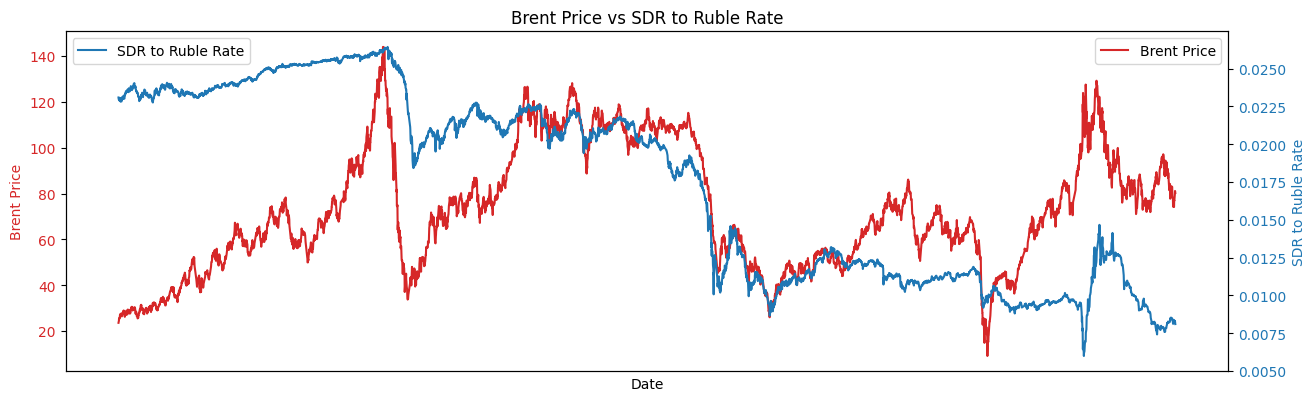

In [42]:
fig, ax1 = plt.subplots(figsize=(15, 5))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Brent Price', color=color)
ax1.plot(df_brent_ruble['Date'], df_brent_ruble['Value'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(["Brent Price"], loc="upper right")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('SDR to Ruble Rate', color='tab:blue')  # we already handled the x-label with ax1
ax2.plot(df_brent_ruble['Date'], df_brent_ruble['sdr_ruble_rate'], color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(["SDR to Ruble Rate"], loc="upper left")

ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
fig.autofmt_xdate()# we set the title
plt.title("Brent Price vs SDR to Ruble Rate")


### Let's zoom in on the brent price and ruble exchange rate during Russia's invasion of Ukraine

In [43]:
start_date = datetime(2022, 1, 1)
end_date = datetime(2022, 4, 1)

In [44]:
df_brent_ruble_2022 = df_brent_ruble[(df_brent_ruble['Date'] >= start_date) & (df_brent_ruble['Date'] <= end_date)]
df_brent_ruble_2022.head()

,Value,Date,sdr_ruble_rate
4385,81.56,2022-01-10,0.009508
4386,84.98,2022-01-11,0.009542
4387,85.83,2022-01-12,0.009571
4388,85.80,2022-01-13,0.009529
4389,87.17,2022-01-14,0.009374


Text(0.5, 1.0, 'Brent Price vs SDR to Ruble Rate from 2022/01 to 2022/04')

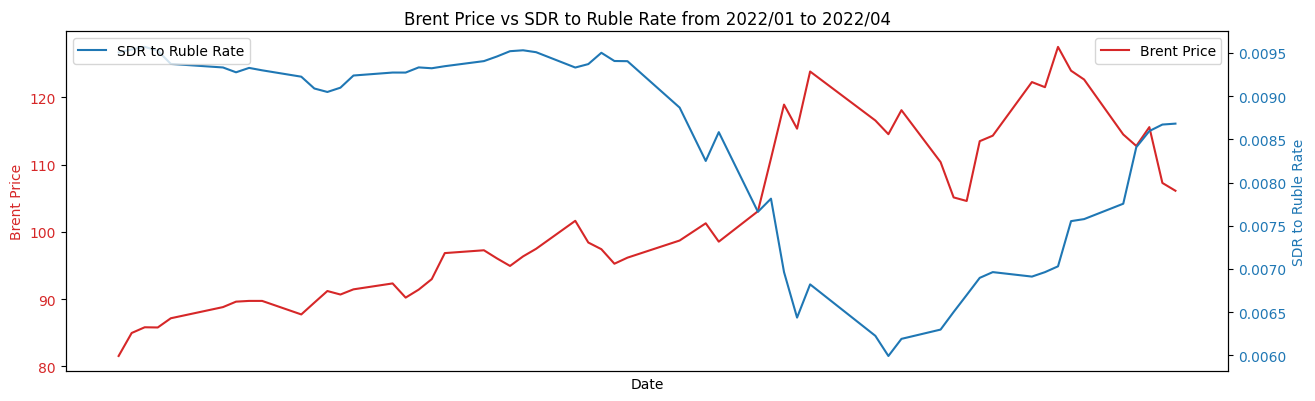

In [45]:
fig, ax1 = plt.subplots(figsize=(15, 5))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Brent Price', color=color)
ax1.plot(df_brent_ruble_2022['Date'], df_brent_ruble_2022['Value'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(["Brent Price"], loc="upper right")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('SDR to Ruble Rate', color='tab:blue')  # we already handled the x-label with ax1
ax2.plot(df_brent_ruble_2022['Date'], df_brent_ruble_2022['sdr_ruble_rate'], color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(["SDR to Ruble Rate"], loc="upper left")

ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
fig.autofmt_xdate()# we set the title

plt.title("Brent Price vs SDR to Ruble Rate from 2022/01 to 2022/04")


In [50]:
df_brent_ruble_2022_gc = df_brent_ruble_2022.drop(columns=["Date"])
df_brent_ruble_2022_gc[["Brent Price", "SDR to Ruble"]] = df_brent_ruble_2022_gc[["Value", "sdr_ruble_rate"]]
df_brent_ruble_2022_gc.drop(columns=["Value", "sdr_ruble_rate"], inplace=True)

In [51]:
granger_mat_2022 = grangers_causation_matrix(df_brent_ruble_2022_gc, variables = df_brent_ruble_2022_gc.columns);

In [52]:
granger_mat_2022

,Brent Price_x,SDR to Ruble_x
Brent Price_y,1.0,0.0
SDR to Ruble_y,0.0,1.0


In [55]:
df_brent_ruble_2022_gc.head()

,Brent Price,SDR to Ruble
4385,81.56,0.009508
4386,84.98,0.009542
4387,85.83,0.009571
4388,85.80,0.009529
4389,87.17,0.009374


In [57]:
corr_coeff_vanilla = np.corrcoef(df_brent_ruble_2022_gc['Brent Price'], df_brent_ruble_2022_gc['SDR to Ruble'])[0, 1]
corr_coeff_vanilla

-0.8293907711803301

In [105]:
import statsmodels.api as sm

In [106]:
data_reg = pd.DataFrame({'X': df_brent_ruble_2022_gc['Brent Price'], 'Y': df_brent_ruble_2022_gc['SDR to Ruble']})
# data_new = sm.add_constant(data_reg)

# model = sm.OLS(data_new['Y'], data_new[['const', 'X']])
# results = model.fit()

In [116]:
data_full = pd.DataFrame({'X': df_brent_ruble['Value'], 'Y': df_brent_ruble['sdr_ruble_rate']})
data_new = sm.add_constant(data_full)

model = sm.OLS(data_new['Y'], data_new[['const', 'X']])
results = model.fit()

In [117]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     169.7
Date:                Sun, 07 Apr 2024   Prob (F-statistic):           3.74e-38
Time:                        23:19:27   Log-Likelihood:                 17859.
No. Observations:                4835   AIC:                        -3.571e+04
Df Residuals:                    4833   BIC:                        -3.570e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0143      0.000     56.798      0.0

In [107]:
data_reg.head()

,X,Y
4385,81.56,0.009508
4386,84.98,0.009542
4387,85.83,0.009571
4388,85.80,0.009529
4389,87.17,0.009374


In [96]:
data_reg['X%'] = data_reg['X'].pct_change()
data_reg['Y%'] = data_reg['Y'].pct_change()

In [101]:
data_reg['Y_diff'] = data_reg['X'].diff()
data_reg['X_diff'] = data_reg['Y'].diff()

# Drop the first row (NaN value resulting from differencing)
data_reg = data_reg.dropna()

In [102]:
# data_reg = pd.DataFrame({'X': df_brent_ruble_2022_gc['Brent Price'], 'Y': df_brent_ruble_2022_gc['SDR to Ruble']})
data_reg = data_reg.fillna(0)
data_new = sm.add_constant(data_reg)

model = sm.OLS(data_new['Y_diff'], data_new[['const', 'X_diff']])
results = model.fit()
# data_new

In [103]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Y_diff   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.036
Date:                Sun, 07 Apr 2024   Prob (F-statistic):              0.314
Time:                        22:54:58   Log-Likelihood:                -149.96
No. Observations:                  54   AIC:                             303.9
Df Residuals:                      52   BIC:                             307.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4254      0.540      0.788      0.4

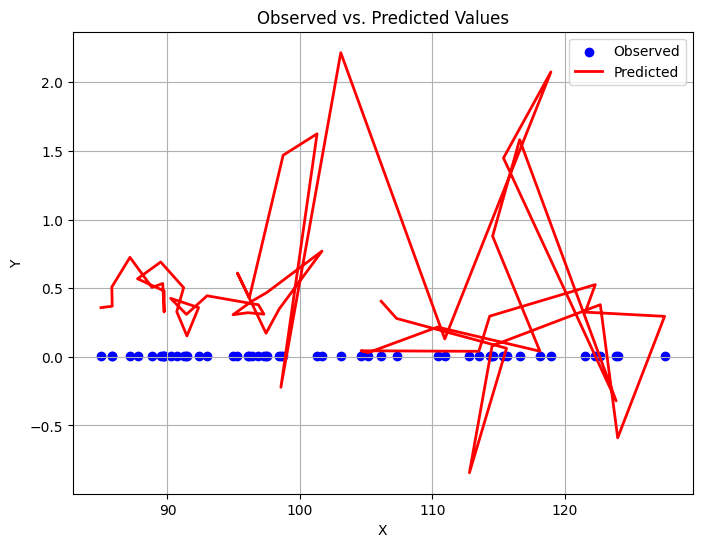

In [104]:
predicted_values = results.predict()
plt.figure(figsize=(8, 6))
plt.scatter(data_new['X'], data_new['Y'], color='blue', label='Observed')
plt.plot(data_new['X'], predicted_values, color='red', linewidth=2, label='Predicted')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Observed vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     116.8
Date:                Sun, 07 Apr 2024   Prob (F-statistic):           5.18e-15
Time:                        22:02:15   Log-Likelihood:                 325.15
No. Observations:                  55   AIC:                            -646.3
Df Residuals:                      53   BIC:                            -642.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0164      0.001     21.987      0.0

In [67]:
residuals = results.resid

# Get statistics on residuals
residual_mean = residuals.mean()
residual_std = residuals.std()
residual_min = residuals.min()
residual_max = residuals.max()
residual_median = residuals.median()

# Print statistics
print("Residual Mean:", residual_mean)
print("Residual Standard Deviation:", residual_std)
print("Minimum Residual:", residual_min)
print("Maximum Residual:", residual_max)
print("Residual Median:", residual_median)

Residual Mean: 1.0676434483966349e-17
Residual Standard Deviation: 0.0006611748236819914
Minimum Residual: -0.0016667340773893523
Maximum Residual: 0.0012489579103691648
Residual Median: -4.3364097012128094e-06


In [68]:
coefficients = results.params
p_values = results.pvalues

# Print coefficients and p-values
print("Coefficients:", coefficients)
print("P-values:", p_values)

Coefficients: const    0.016435
X       -0.000079
dtype: float64
P-values: const    2.632172e-28
X        5.184043e-15
dtype: float64


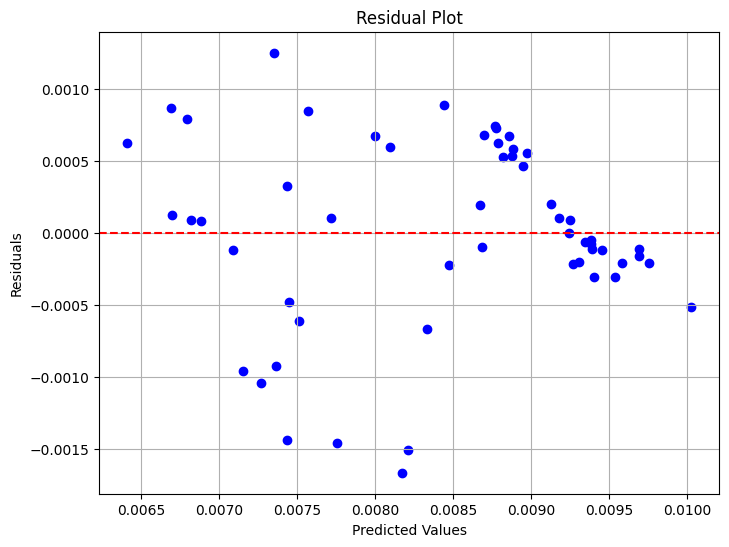

In [69]:
predicted_values = results.predict()
residuals = results.resid

# Plot graph of predicted values vs. residuals
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals, color='blue')
plt.axhline(y=0, color='r', linestyle='--')  # Add horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

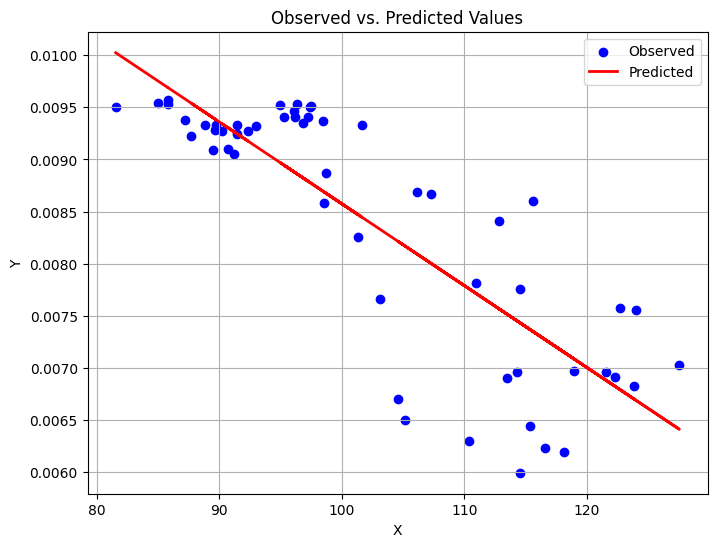

In [71]:
plt.figure(figsize=(8, 6))
plt.scatter(data_new['X'], data_new['Y'], color='blue', label='Observed')
plt.plot(data_new['X'], predicted_values, color='red', linewidth=2, label='Predicted')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Observed vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

/Users/shrek/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


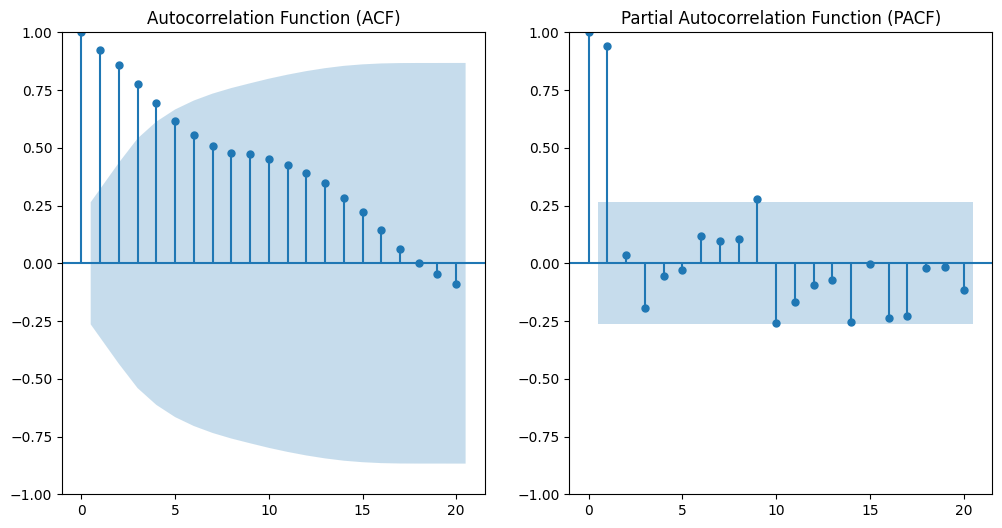

Ljung-Box test results (p-values):
 1     1.915804e-12
2     6.152993e-21
3     7.756084e-28
4     2.432907e-33
5     1.355847e-37
6     5.418413e-41
7     8.926489e-44
8     3.310592e-46
9     1.099573e-48
10    6.401652e-51
Name: lb_pvalue, dtype: float64


In [114]:
cf = sm.tsa.acf(data_reg['X'], fft=False)
pacf = sm.tsa.pacf(data_reg['X'], method='ols')

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sm.graphics.tsa.plot_acf(data_reg['X'], lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.subplot(1, 2, 2)
sm.graphics.tsa.plot_pacf(data_reg['X'], lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Perform Ljung-Box test for autocorrelation
ljung_box_results = sm.stats.acorr_ljungbox(data_reg['X'], lags=10)
print("Ljung-Box test results (p-values):\n", ljung_box_results['lb_pvalue'])

In [115]:
adf_test_results = sm.tsa.adfuller(data_reg['X'])
print("ADF test results (p-value):", adf_test_results[1])

# Perform Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity
kpss_test_results = sm.tsa.kpss(data_reg['X'])
print("KPSS test results (p-value):", kpss_test_results[1])

ADF test results (p-value): 0.40983362086093533
KPSS test results (p-value): 0.01


/Users/shrek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
